# Modeling

## Initial Settings

In [1]:
# load libraries

import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
%matplotlib inline
import altair as alt

from sklearn.cluster import KMeans, dbscan 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [11]:
# Set plot parameters

plt.rcParams['figure.figsize'] = (10,6)
alt.renderers.enable("notebook")
np.random.seed(42)

In [12]:
# Load dataset created in the Data Wrangling script

path_data = './data/data_101219.geojson'

data = gpd.read_file(path_data)

In [13]:
# Allow visualization of all columns

pd.set_option('display.max_columns', None)
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.0,(POLYGON ((31.90590570688292 29.85788702426048...


### Aqueduct attributes for clustering

Baseline water stress: bws_raw  
Baseline water depletion: bwd_raw  
Interannual variability: iav_raw  
Seasonal variability: sev_raw  
Groundwater table decline: gtd_raw  
Riverine flood risk: rfr_raw  
Coastal flood risk: cfr_raw  
Drought risk: drr_raw  
Untreated connected wastewater: ucw_raw  
Unimproved/no drinking water: udw_raw  
Unimproved/no sanitation: usa_raw  

## Create Pipeline

1. Standard scaler
1. kmeans
1. optimize K using elbow method
1. generate final Kmeans clusters
1. join clusters back to original data (unscaled)
1. run DBScan cluster analysis
1. quick visualizations

## Checking dataset and dropping all NA Values

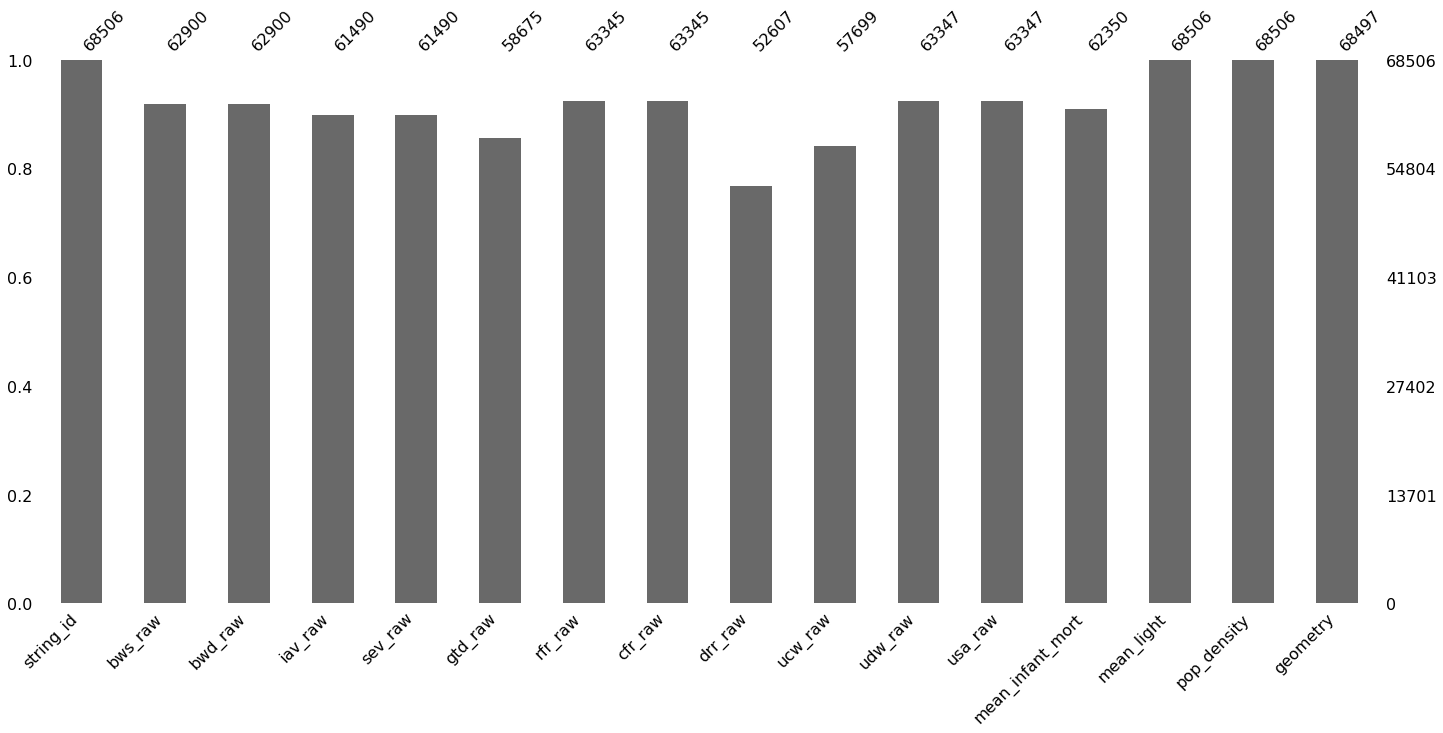

In [14]:
import missingno as msno
msno.bar(data)

In [15]:
data = data.dropna()
data.shape

(42823, 16)

## Physical Risk Variables Kmeans cluster

In [16]:
physical_risk_cols = ['ucw_raw', 'udw_raw', 'usa_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
physical_risk = data[physical_risk_cols].copy()
physical_risk.head()

,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
89,-1.0,0.217479,0.708491,33.800000,0.000000,0.000000
90,-1.0,0.217479,0.708491,44.714826,0.081541,0.000000
92,-1.0,0.217479,0.708491,39.015000,0.188762,208.386554
93,-1.0,0.217479,0.708491,39.015000,0.246018,189.688560
94,-1.0,0.217479,0.708491,39.038256,0.097656,75.549332


In [18]:
scaler = StandardScaler()
physical_risk_scaled = scaler.fit_transform(physical_risk)

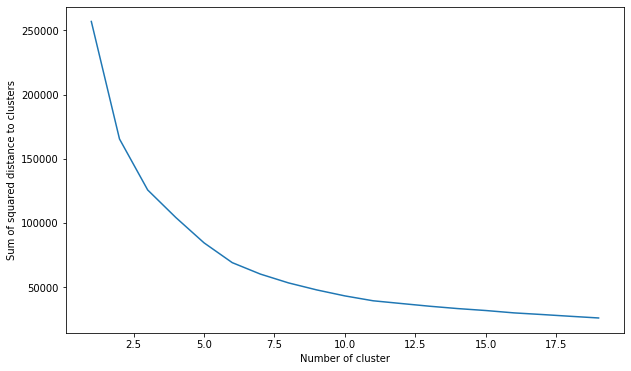

In [19]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(physical_risk_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

#### The elbow function shows that 10 clusters is a good number, since the reduction in the SSE by increasing more clusters is minimal

In [20]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(physical_risk_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
data['PR_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3


In [22]:
data.groupby('PR_labels').size()

PR_labels
0    11683
1     2182
2      133
3     3673
4      656
5    16469
6     1937
7       22
8     3894
9     2174
dtype: int64

## Depletion Variables Kmeans cluster

In [23]:
depletion_cols = ['bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
depletion_risk = data[depletion_cols].copy()
depletion_risk.head()

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,mean_infant_mort,mean_light,pop_density
89,0.126168,0.038672,0.513708,1.269381,0.843958,33.800000,0.000000,0.000000
90,0.126168,0.038672,0.513708,1.269381,0.843958,44.714826,0.081541,0.000000
92,0.126168,0.038672,0.513708,1.269381,0.162628,39.015000,0.188762,208.386554
93,0.126168,0.038672,0.513708,1.269381,0.063822,39.015000,0.246018,189.688560
94,0.126168,0.038672,0.513708,1.269381,0.843958,39.038256,0.097656,75.549332


In [24]:
depletion_scaled = scaler.fit_transform(depletion_risk)

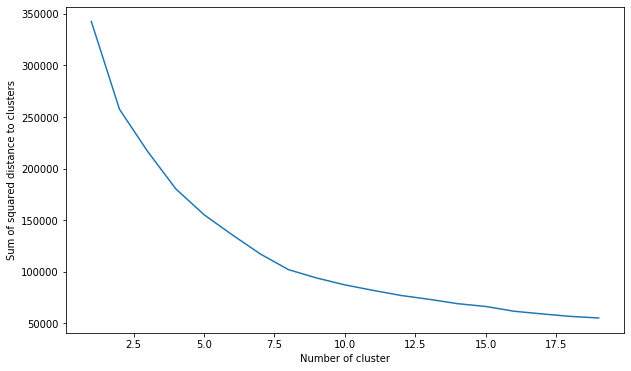

In [25]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(depletion_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

In [26]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(depletion_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
data['deplete_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3,5


In [28]:
data.groupby('deplete_labels').size()

deplete_labels
0     5633
1    17537
2        1
3     1746
4     2252
5    13062
6     1991
7       51
8      408
9      142
dtype: int64

## Flood/Drought variables Kmeans cluster

In [30]:
floodrought_cols = ['rfr_raw', 'cfr_raw', 'drr_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
floodrought_risk = data[floodrought_cols].copy()
floodrought_risk.head()

,rfr_raw,cfr_raw,drr_raw,mean_infant_mort,mean_light,pop_density
89,0.102012,0.0,2.21514,33.800000,0.000000,0.000000
90,0.102012,0.0,2.21514,44.714826,0.081541,0.000000
92,0.102012,0.0,2.21514,39.015000,0.188762,208.386554
93,0.102012,0.0,2.21514,39.015000,0.246018,189.688560
94,0.102012,0.0,2.21514,39.038256,0.097656,75.549332


In [31]:
floodrought_scaled = scaler.fit_transform(floodrought_risk)
floodrought_scaled

array([[ 5.62070665, -0.0620456 , -0.09433314,  0.51062163, -0.37581312,
        -0.18402743],
       [ 5.62070665, -0.0620456 , -0.09433314,  0.98140357, -0.36407751,
        -0.18402743],
       [ 5.62070665, -0.0620456 , -0.09433314,  0.73555677, -0.34864604,
        -0.14850247],
       ...,
       [-0.534529  , -0.0620456 , -0.86462922, -0.72485026, -0.37079218,
        -0.18402743],
       [-0.534529  , -0.0620456 , -0.86462922, -0.70867563, -0.36731886,
        -0.18402743],
       [-0.534529  , -0.0620456 , -0.86462922, -0.08190885, -0.36547176,
        -0.18402743]])

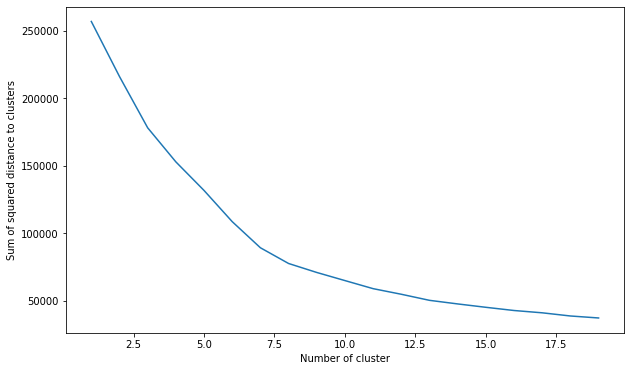

In [32]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(floodrought_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

In [33]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(floodrought_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [34]:
data['floodrought_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels,floodrought_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3,5,2


In [35]:
data.groupby('floodrought_labels').size()

floodrought_labels
0     1479
1    14270
2      524
3     2651
4     6301
5        5
6       24
7    17312
8       69
9      188
dtype: int64

## DBScan cluster

#### First, we need to convert the CRS to 6933, to have the coordinates in meters. Then we convert the geometries into points and extract separately the 'x' and 'y' coordinates.

In [39]:
data = data.to_crs({'init': 'epsg:6933'})

In [41]:
data_point = data.copy()
data_point.geometry = data_point['geometry'].centroid
data_point['x'] = data_point.geometry.x
data_point['y'] = data_point.geometry.y

pd.options.display.float_format = '{:.2f}'.format
data_point.head(5)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels,floodrought_labels,x,y
89,111081-ERI.2_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,33.80,0.00,0.00,POINT (3668636.210972508 2200941.282854759),3,5,2,3668636.21,2200941.28
90,111081-ERI.6_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,44.71,0.08,0.00,POINT (3656272.052900172 2193473.713510732),3,5,2,3656272.05,2193473.71
92,111081-SDN.11_1-1775,0.13,0.04,0.51,1.27,0.16,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.19,208.39,POINT (3622482.640097156 2278821.206874764),3,5,2,3622482.64,2278821.21
93,111081-SDN.11_1-1930,0.13,0.04,0.51,1.27,0.06,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.25,189.69,POINT (3638748.637192579 2300938.110996285),3,5,2,3638748.64,2300938.11
94,111081-SDN.11_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,39.04,0.10,75.55,POINT (3632484.282508446 2231674.510500768),3,5,2,3632484.28,2231674.51


#### Then we scale the data, including the Kmeans labels

In [43]:
data_scaled = data_point.copy()
data_scaled = data_scaled.drop(['string_id', 'geometry'], axis=1)
col_names = list(data_scaled.columns)

In [44]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled))
data_scaled.columns = col_names
data_scaled.head()

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,PR_labels,deplete_labels,floodrought_labels,x,y
0,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.51,-0.38,-0.18,-0.27,1.07,-0.74,0.24,-0.03
1,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.98,-0.36,-0.18,-0.27,1.07,-0.74,0.23,-0.03
2,-0.00,-0.02,0.05,1.81,0.03,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.35,-0.15,-0.27,1.07,-0.74,0.23,-0.01
3,-0.00,-0.02,0.05,1.81,-0.06,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.34,-0.15,-0.27,1.07,-0.74,0.23,-0.00
4,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.36,-0.17,-0.27,1.07,-0.74,0.23,-0.02


#### Creating the clusters

In [67]:
eps = .75
min_samples = 15

cores, labels = dbscan(data_scaled, eps = eps, min_samples = min_samples)

print(len(cores))

23963


#### Joining labels to unscaled dataframe

In [68]:
data['DBScan_labels'] = labels
data.head()

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels,floodrought_labels,DBScan_labels
89,111081-ERI.2_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,33.80,0.00,0.00,"(POLYGON ((3668902.175752448 2204796.49083447,...",3,5,2,-1
90,111081-ERI.6_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,44.71,0.08,0.00,(POLYGON ((3667654.988035774 2205403.562746873...,3,5,2,-1
92,111081-SDN.11_1-1775,0.13,0.04,0.51,1.27,0.16,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.19,208.39,(POLYGON ((3627835.787313797 2291356.226409634...,3,5,2,-1
93,111081-SDN.11_1-1930,0.13,0.04,0.51,1.27,0.06,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.25,189.69,(POLYGON ((3650397.602799883 2309750.193333262...,3,5,2,-1
94,111081-SDN.11_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,39.04,0.10,75.55,(POLYGON ((3632098.253019236 2264728.515082323...,3,5,2,-1


In [69]:
# Checking number of clusters

num_clusters = data['DBScan_labels'].nunique() - 1
print("number of clusters = ", num_clusters)

number of clusters =  198


In [71]:
# Checking the number of basins per cluster

print(data['DBScan_labels'].value_counts(dropna =False))

-1      13910
 51      3186
 80      2426
 71      2294
 52      1257
        ...  
 120       14
 61        14
 185       14
 62        13
 67        12
Name: DBScan_labels, Length: 199, dtype: int64


## Quick visualizations

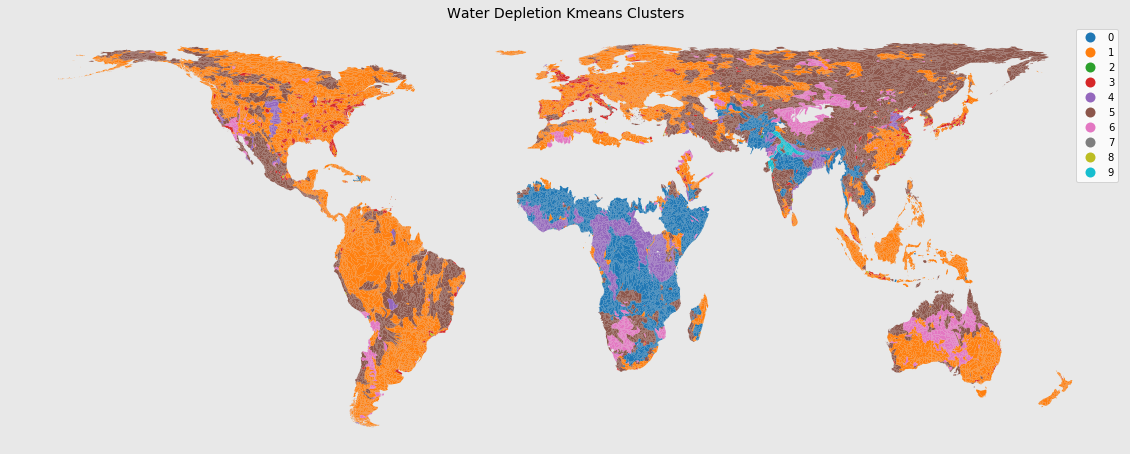

In [75]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'deplete_labels', legend=True, categorical = True)
ax.set_title("Water Depletion Kmeans Clusters", fontsize=14)
ax.set_axis_off()

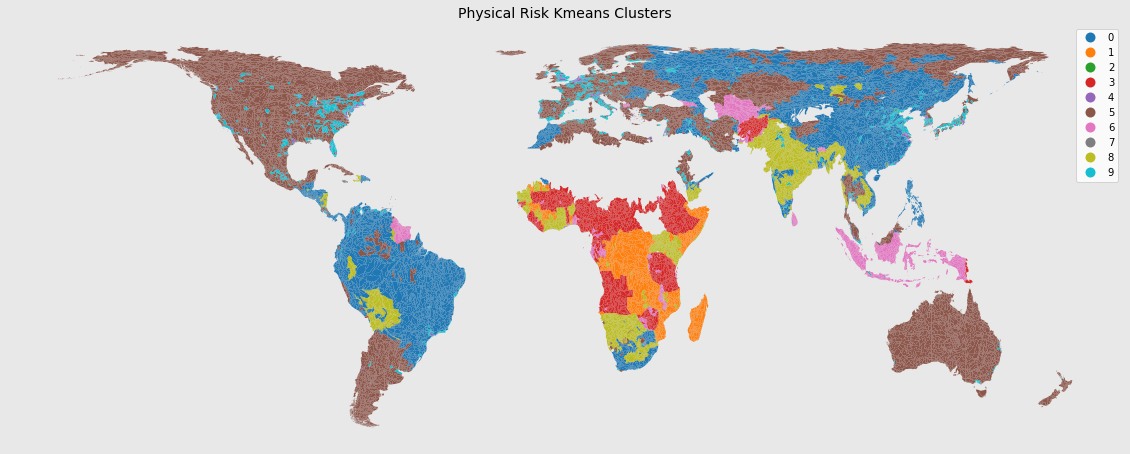

In [76]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'PR_labels', legend=True, categorical = True)
ax.set_title("Physical Risk Kmeans Clusters", fontsize=14)
ax.set_axis_off()

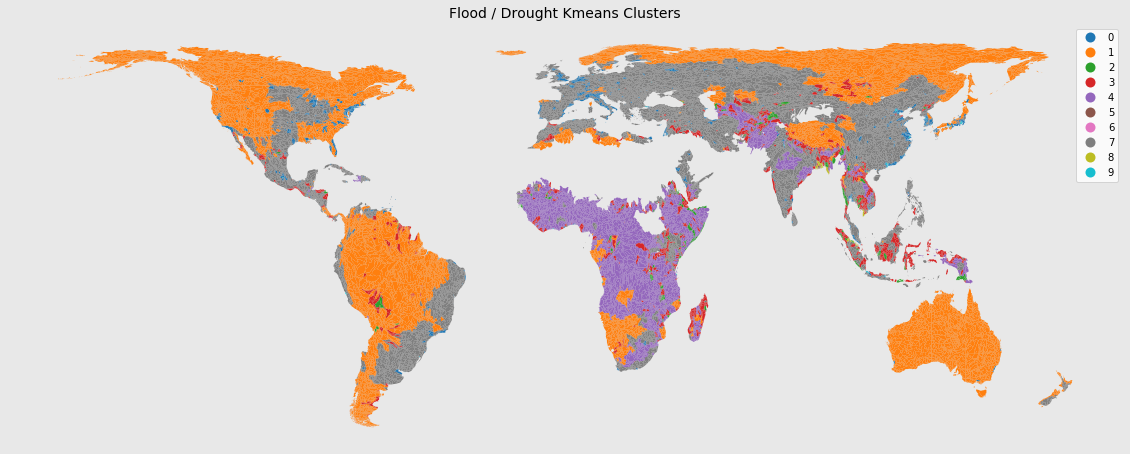

In [77]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'floodrought_labels', legend=True, categorical = True)
ax.set_title("Flood / Drought Kmeans Clusters", fontsize=14)
ax.set_axis_off()

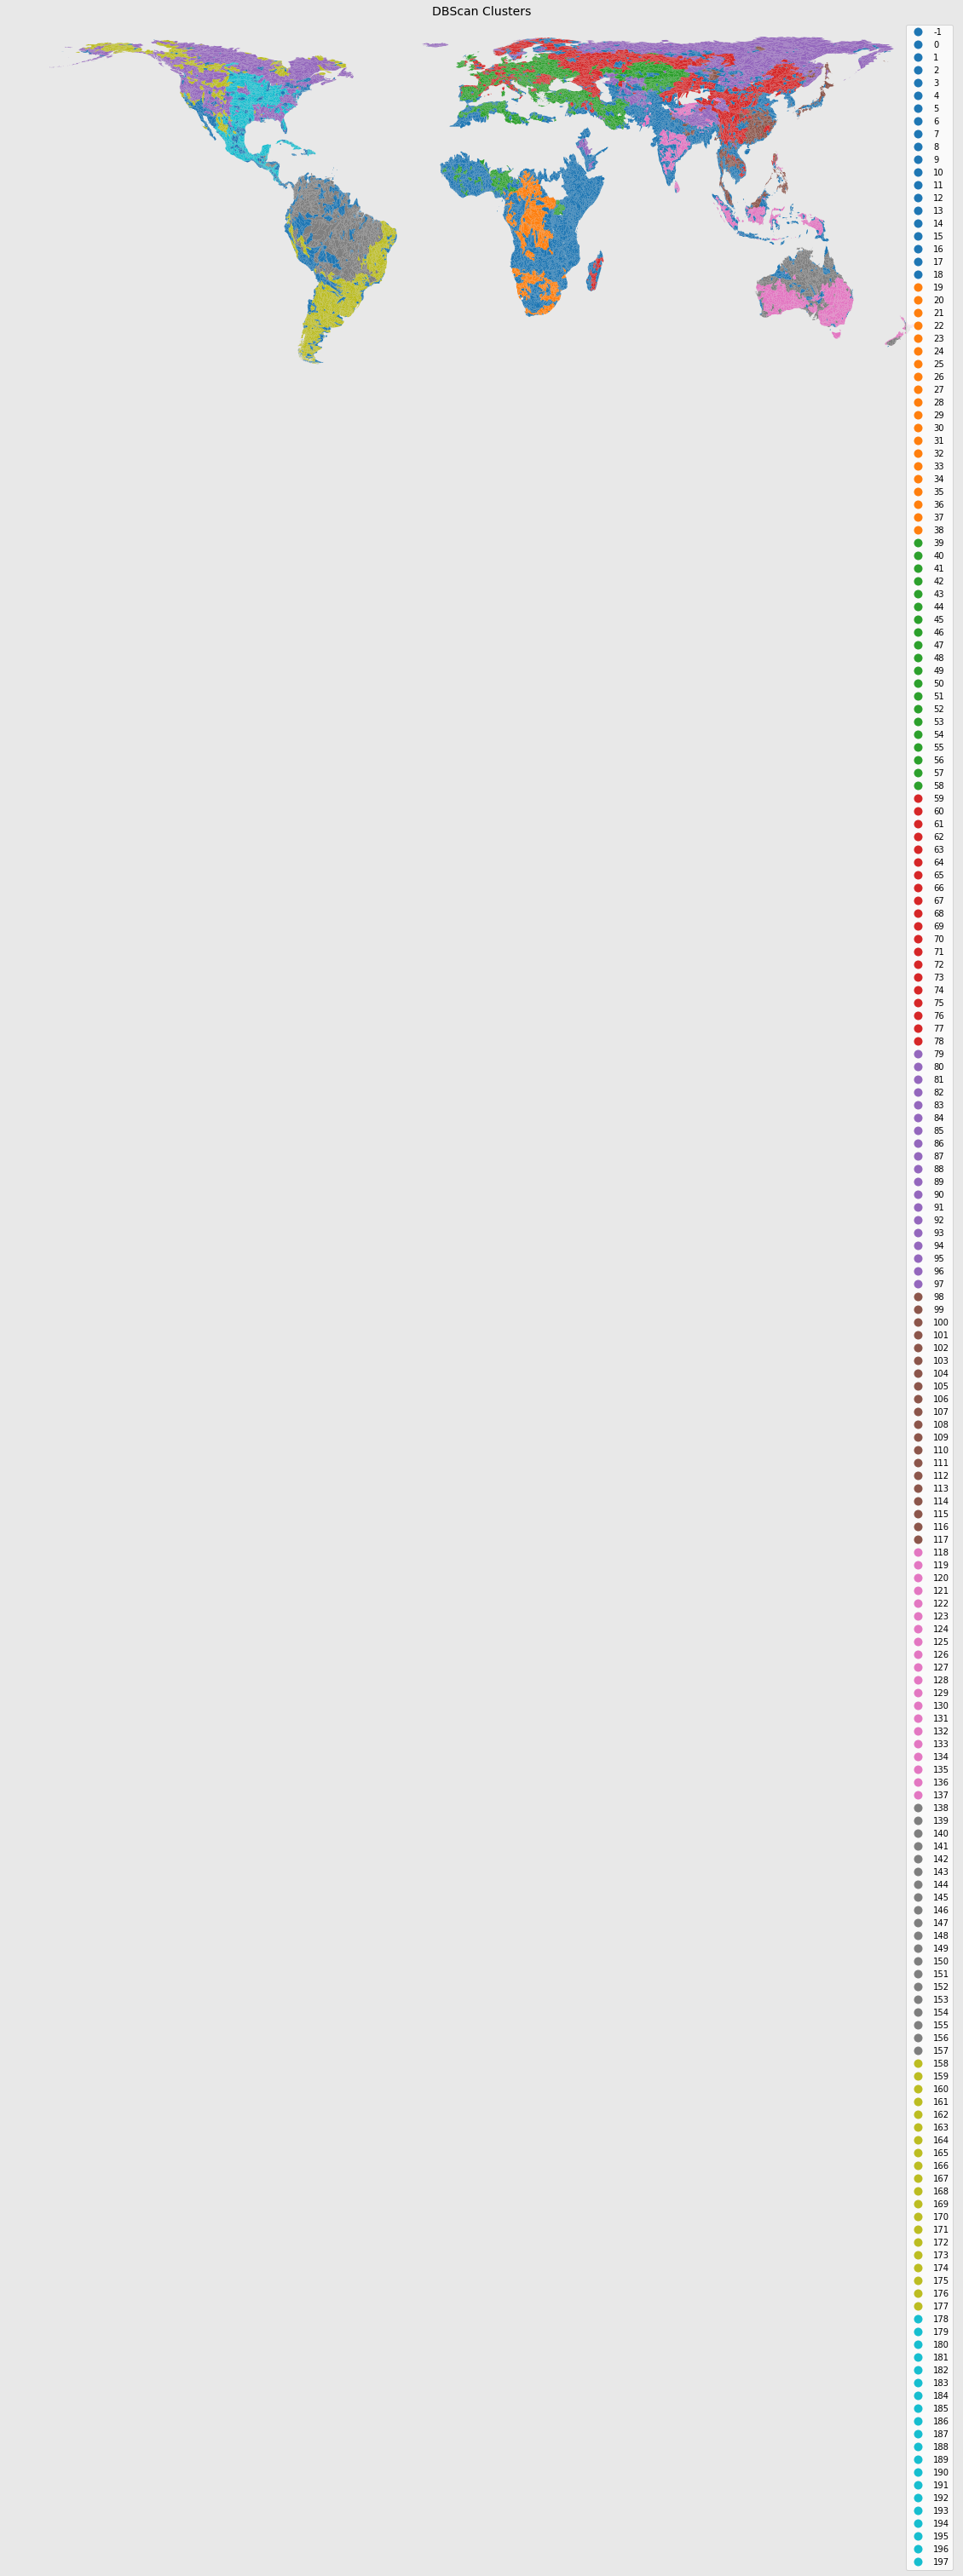

In [74]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'DBScan_labels', legend=True, categorical = True)
ax.set_title("DBScan Clusters", fontsize=14)
ax.set_axis_off()

In [73]:
data.to_file("./data/data_with_labels_and_DBScan.geojson", driver='GeoJSON')